In [1]:
import os
import tensorflow as tf


def regularized_padded_conv(*args, **kwargs):
    return tf.keras.layers.Conv2D(*args, **kwargs, padding='same', kernel_regularizer=_regularizer,
                                  kernel_initializer='he_normal', use_bias=False)


def bn_leaky_relu(x):
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.LeakyReLU()(x)


def shortcut(x, filters, stride, mode):
    if x.shape[-1] == filters:
        return x
    elif mode == 'B':
        return regularized_padded_conv(filters, 1, strides=stride)(x)
    elif mode == 'B_original':
        x = regularized_padded_conv(filters, 1, strides=stride)(x)
        return tf.keras.layers.BatchNormalization()(x)
    elif mode == 'A':
        return tf.pad(tf.keras.layers.MaxPool2D(1, stride)(x) if stride>1 else x,
                      paddings=[(0, 0), (0, 0), (0, 0), (0, filters - x.shape[-1])])
    else:
        raise KeyError("Parameter shortcut_type not recognized!")
    

def original_block(x, filters, stride=1, **kwargs):
    c1 = regularized_padded_conv(filters, 3, strides=stride)(x)
    c2 = regularized_padded_conv(filters, 3)(bn_leaky_relu(c1))
    c2 = tf.keras.layers.BatchNormalization()(c2)
    
    mode = 'B_original' if _shortcut_type == 'B' else _shortcut_type
    x = shortcut(x, filters, stride, mode=mode)
    return tf.keras.layers.LeakyReLU()(x + c2)
    
    
def preactivation_block(x, filters, stride=1, preact_block=False):
    flow = bn_leaky_relu(x)
    if preact_block:
        x = flow
        
    c1 = regularized_padded_conv(filters, 3, strides=stride)(flow)
    if _dropout:
        c1 = tf.keras.layers.Dropout(_dropout)(c1)
        
    c2 = regularized_padded_conv(filters, 3)(bn_leaky_relu(c1))
    x = shortcut(x, filters, stride, mode=_shortcut_type)
    return x + c2


def bootleneck_block(x, filters, stride=1, preact_block=False):
    flow = bn_leaky_relu(x)
    if preact_block:
        x = flow
         
    c1 = regularized_padded_conv(filters//_bootleneck_width, 1)(flow)
    c2 = regularized_padded_conv(filters//_bootleneck_width, 3, strides=stride)(bn_leaky_relu(c1))
    c3 = regularized_padded_conv(filters, 1)(bn_leaky_relu(c2))
    x = shortcut(x, filters, stride, mode=_shortcut_type)
    return x + c3


def group_of_blocks(x, block_type, num_blocks, filters, stride, block_idx=0):
    global _preact_shortcuts
    preact_block = True if _preact_shortcuts or block_idx == 0 else False
    
    x = block_type(x, filters, stride, preact_block=preact_block)
    for i in range(num_blocks-1):
        x = block_type(x, filters)
    return x


def Resnet(input_shape, n_classes, l2_reg=1e-4, group_sizes=(2, 2, 2), features=(16, 32, 64), strides=(1, 2, 2),
           shortcut_type='B', block_type='preactivated', first_conv={"filters": 16, "kernel_size": 3, "strides": 1},
           dropout=0, cardinality=1, bootleneck_width=4, preact_shortcuts=True):
    
    global _regularizer, _shortcut_type, _preact_projection, _dropout, _cardinality, _bootleneck_width, _preact_shortcuts
    _bootleneck_width = bootleneck_width # used in ResNeXts and bootleneck blocks
    _regularizer = tf.keras.regularizers.l2(l2_reg)
    _shortcut_type = shortcut_type # used in blocks
    _cardinality = cardinality # used in ResNeXts
    _dropout = dropout # used in Wide ResNets
    _preact_shortcuts = preact_shortcuts
    
    block_types = {'preactivated': preactivation_block,
                   'bootleneck': bootleneck_block,
                   'original': original_block}
    
    selected_block = block_types[block_type]
    inputs = tf.keras.layers.Input(shape=input_shape)
    flow = regularized_padded_conv(**first_conv)(inputs)
    
    if block_type == 'original':
        flow = bn_leaky_relu(flow)
    
    for block_idx, (group_size, feature, stride) in enumerate(zip(group_sizes, features, strides)):
        flow = group_of_blocks(flow,
                               block_type=selected_block,
                               num_blocks=group_size,
                               block_idx=block_idx,
                               filters=feature,
                               stride=stride)
    
    if block_type != 'original':
        flow = bn_leaky_relu(flow)
    
    flow = tf.keras.layers.GlobalAveragePooling2D()(flow)
    outputs = tf.keras.layers.Dense(n_classes, kernel_regularizer=_regularizer)(flow)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def load_weights_func(model, model_name):
    try: model.load_weights(os.path.join('saved_models', model_name + '.tf'))
    except tf.errors.NotFoundError: print("No weights found for this model!")
    return model

# def cifar_wide_resnet(N, K, block_type='preactivated', shortcut_type='B', dropout=0, l2_reg=2.5e-4):
#     assert (N-4) % 6 == 0, "N-4 has to be divisible by 6"
#     lpb = (N-4) // 6 # layers per block - since N is total number of convolutional layers in Wide ResNet
#     model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(lpb0, lpb, lpb), features=(16*K, 32*K, 64*K),
#                    strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
#                    block_type=block_type, dropout=dropout, preact_shortcuts=True)
#     return model

def cifar_wide_resnet(N, K, block_type='preactivated', shortcut_type='B', dropout=0, l2_reg=2.5e-4):
    assert (N-4) % 6 == 0, "N-4 has to be divisible by 6"
    lpb = (N-4) // 6 # layers per block - since N is total number of convolutional layers in Wide ResNet
    model = Resnet(input_shape=(32, 32, 3), n_classes=100, l2_reg=l2_reg, group_sizes=(lpb, lpb, lpb), features=(16*K, 32*K, 64*K),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type=block_type, dropout=dropout, preact_shortcuts=True)
    return model



def cifar_WRN_16_4(shortcut_type='B', load_weights=False, dropout=0, l2_reg=2.5e-4):
    model = cifar_wide_resnet(16, 4, 'preactivated', shortcut_type, dropout=dropout, l2_reg=l2_reg)
    if load_weights: model = load_weights_func(model, 'cifar_WRN_16_4')
    return model


def cifar_WRN_40_4(shortcut_type='B', load_weights=False, dropout=0, l2_reg=2.5e-4):
    model = cifar_wide_resnet(40, 4, 'preactivated', shortcut_type, dropout=dropout, l2_reg=l2_reg)
    if load_weights: model = load_weights_func(model, 'cifar_WRN_40_4')
    return model


def cifar_WRN_16_8(shortcut_type='B', load_weights=False, dropout=0, l2_reg=2.5e-4):
    model = cifar_wide_resnet(16, 8, 'preactivated', shortcut_type, dropout=dropout, l2_reg=l2_reg)
    if load_weights: model = load_weights_func(model, 'cifar_WRN_16_8')
    return model


def cifar_WRN_28_10(shortcut_type='B', load_weights=False, dropout=0, l2_reg=2.5e-4):
    model = cifar_wide_resnet(28, 10, 'preactivated', shortcut_type, dropout=dropout, l2_reg=l2_reg)
    if load_weights: model = load_weights_func(model, 'cifar_WRN_28_10')
    return model

2024-05-22 17:30:38.929058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 17:30:38.929176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 17:30:39.044759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import logging
logging.getLogger('tensorflow').disabled = True

try:
    os.chdir('cifar-vs-tensorflow2')
except:
    pass

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
if not tf.test.is_gpu_available():
    print("GPU is not available, change Runtime!")

import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from tensorflow.keras.utils import plot_model

In [3]:
ds = tfds.load('cifar100', as_supervised=True)
std = tf.reshape((0.2023, 0.1994, 0.2010), shape=(1, 1, 3))
mean= tf.reshape((0.4914, 0.4822, 0.4465), shape=(1, 1, 3))

def train_prep(x, y):
    x = tf.cast(x, tf.float32)/255.
    x = tf.image.random_flip_left_right(x)
    x = tf.image.pad_to_bounding_box(x, 4, 4, 40, 40)
    x = tf.image.random_crop(x, (32, 32, 3))
    x = (x - mean) / std
    return x, y

def valid_prep(x, y):
    x = tf.cast(x, tf.float32)/255.
    x = (x - mean) / std
    return x, y

ds['train'] = ds['train'].map(train_prep).shuffle(5000).repeat().batch(128).prefetch(-1)
ds['test'] = ds['test'].map(valid_prep).batch(512).prefetch(-1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incompleteGBP192/cifar100-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incompleteGBP192/cifar100-test.tfrecord*...:   0%|         …

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [4]:
model = cifar_WRN_16_4(shortcut_type='B')

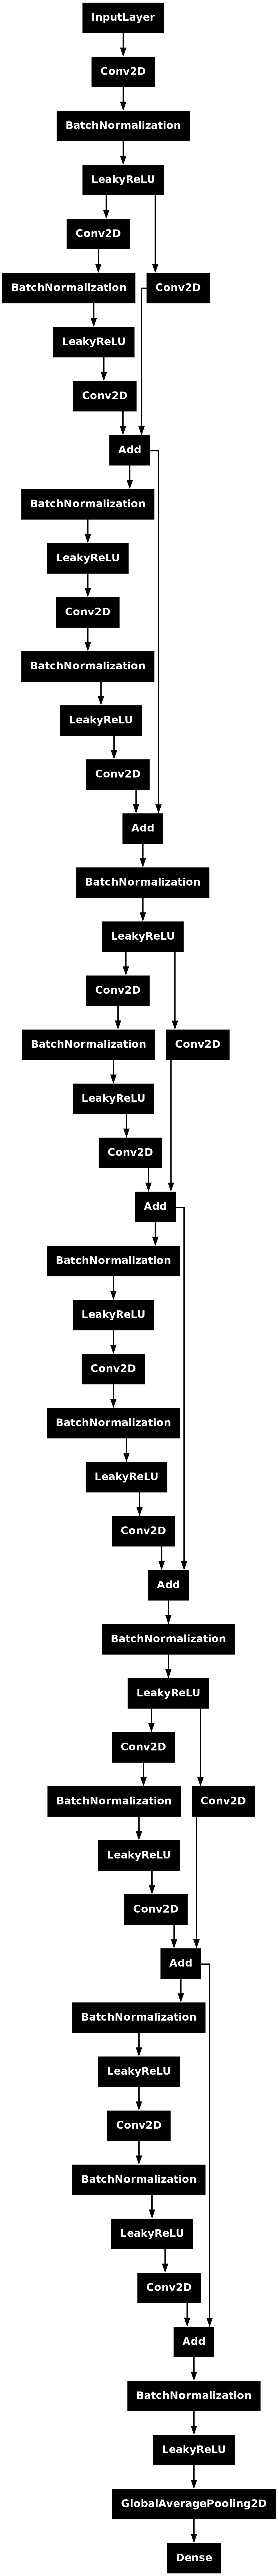

In [5]:
plot_model(model)

In [6]:
checkpoint_path = "weights_after_epoch_WRN_{epoch:02d}.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only=True,  # Only save the weights, not the entire model
    save_freq='epoch'
)

In [7]:
model.save_weights(checkpoint_path.format(epoch=0))

In [8]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[400, 32000, 48000], values=[0.01, 0.1, 0.01, 0.001])
optimizer = tf.keras.optimizers.SGD(schedule, momentum=0.9)

model.compile(optimizer, loss_fn, metrics=['accuracy'])

In [9]:
training_steps = 64000
validation_interval = 2000

model.fit(ds['train'], steps_per_epoch=validation_interval, epochs=training_steps//validation_interval, validation_data=ds['test'], callbacks=[checkpoint_callback])

Epoch 1/32
   1/2000 ━━━━━━━━━━━━━━━━━━━━ 11:55:23 21s/step - accuracy: 0.0078 - loss: 5.9039

I0000 00:00:1716399131.800963      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 189s 84ms/step - accuracy: 0.1537 - loss: 4.6206 - val_accuracy: 0.3052 - val_loss: 3.3189
Epoch 2/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.4058 - loss: 2.7336 - val_accuracy: 0.2870 - val_loss: 3.5798
Epoch 3/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.5038 - loss: 2.3107 - val_accuracy: 0.4487 - val_loss: 2.6486
Epoch 4/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.5515 - loss: 2.1669 - val_accuracy: 0.4404 - val_loss: 2.8614
Epoch 5/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.5756 - loss: 2.1026 - val_accuracy: 0.5007 - val_loss: 2.5631
Epoch 6/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.5926 - loss: 2.0662 - val_accuracy: 0.4653 - val_loss: 2.9290
Epoch 7/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.6027 - loss: 2.0470 - val_accuracy: 0.5148 - val_loss: 2.5275
Epoch 8/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.6115 - lo

In [10]:
prediction = model.predict(ds['test'])
prediction = tf.argmax(prediction, axis=-1)

ground_truth = tf.concat([y for x, y in ds['test']], 0)
print(f"Accuracy of the model: {np.mean(prediction==ground_truth) * 100:6.3f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step
Accuracy of the model: 74.280
